In [4]:
# Plot gdp per capita and cultural_index per capita on the same graph for every region
# to show how the cultural index can completer the gdp per capita index

In [5]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np

from dotenv import load_dotenv

load_dotenv()
import os

import sqlite3

DB_PATH = os.getenv("DB_PATH")
DATA_PATH = "data"

conn = sqlite3.connect(DB_PATH)

In [6]:
# Load GDP DATA

In [7]:


def get_population(data_path_environment):
    pop_region = pd.read_csv(
        data_path_environment
        + "/ENS - Cultural Index - Countries Databases - population_region.csv"
    )
    pop_value = pd.read_csv(
        data_path_environment
        + "/ENS - Cultural Index - Countries Databases - population_value.csv"
    )
    df_population = pd.merge(pop_region, pop_value, on="region_code_atlas")

    df_population = df_population[~df_population["value"].isna()]
    df_population["value"] = df_population["value"].apply(lambda x: x.replace(",", "."))
    df_population["value"] = df_population["value"].astype(float)
    df_population["year"] = df_population["year"].astype(int)
    df_population = df_population.drop_duplicates()

    df_equiv = (
        df_population[["region_code", "region_code_atlas"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    df_population = df_population.drop("region_code", axis=1)
    df_population = df_population.drop_duplicates().reset_index(drop=True)

    # in case there is two different values for the same region_code_atlas/year by mistakes, things could add up
    df_population = df_population.drop_duplicates(
        ["region_code_atlas", "year"], keep="first"
    )
    df_population = df_population.dropna().reset_index(drop=True)

    # create a new DataFrame with year values for every 10 years
    # new_years = list(range(min(df_population['year']), max(df_population['year'])+1, 10))

    full_list = []
    for region_code in list(set(df_population["region_code_atlas"])):
        df_population_filtered = df_population[
            df_population["region_code_atlas"] == region_code
        ]

        # create a new DataFrame with year values for every 10 years
        new_years = list(
            range(
                min(df_population_filtered["year"]),
                max(df_population_filtered["year"]) + 1,
                10,
            )
        )

        new_df = pd.DataFrame({"year": new_years})
        new_df["region_code_atlas"] = region_code

        new_df = pd.merge(
            new_df,
            df_population_filtered,
            on=["year", "region_code_atlas"],
            how="outer",
        )
        new_df = new_df.sort_values("year")
        new_df["value"] = new_df["value"].interpolate(method="linear")
        new_df = new_df.dropna().reset_index(drop=True)

        full_list.append(new_df)

    df_years = pd.concat([x for x in full_list])
    df_years = df_years.reset_index(drop=True)

    final = pd.merge(df_equiv, df_years, on="region_code_atlas")
    final = final.groupby(["region_code", "year"])["value"].sum().reset_index()
    df_years = final.rename(columns={"value": "population"})

    return df_years



def get_maddison_data(data_path_environment):
    # country_code_maddison #year #gdp_per_capita
    df_maddison = pd.read_csv(
        data_path_environment + "/gdp_per_capita_maddison.csv", index_col=[0]
    )

    # region_code #code_country_maddison #code_country
    gdp_equiv = pd.read_csv(
        data_path_environment
        + "/ENS - Cultural Index - Countries Databases - gdp_consolidate_table.csv"
    )
    gdp_equiv = gdp_equiv.dropna().reset_index(drop=True)
    gdp_equiv = gdp_equiv[["region_code", "code_country_maddison"]]
    gdp_equiv.columns = ["region_code", "country_code_maddison"]

    df_maddison_stats = pd.merge(gdp_equiv, df_maddison, on="country_code_maddison")

    return df_maddison_stats

In [8]:
data_env_path = '/Users/charlesdedampierre/Desktop/ENS Projects/cultural_index/src/enricher/data_env'

In [102]:
data_gdp = get_maddison_data(data_env_path)
data_gdp =data_gdp[data_gdp['year']<=1850]

# Individuals Regions
df_score_region = pd.read_sql_query("SELECT * FROM region_score", conn)
region = pd.read_sql_query("SELECT * FROM regions", conn)
data_gdp = pd.merge(data_gdp, region, on = 'region_code')
data_gdp.to_sql('gdp', conn, if_exists = 'replace', index=False)


4285

In [10]:
import plotly.express as px
import plotly

fig = px.scatter(data_gdp, 
              x="year", 
              y="gdp_per_capita", 
              facet_col="region_code", 
              facet_col_wrap=6, 
              width = 3000, 
              height = 3000, 
              template = 'simple_white')


fig.update_xaxes(tickmode='linear', dtick=200)
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))

for region_name in data_gdp['region_code'].unique():
    fig.update_xaxes(title_text='year', col=region_name)
    

plotly.offline.plot(fig)

'temp-plot.html'

In [11]:
def interpolate_function(df, value="value", category="region_code", year="year"):
    df_interpolated_list = []
    for reg in set(df[category]):
        res = df[df[category] == reg]

        min_date = min(res["year"])
        max_date = max(res["year"])

        year_range = np.arange(round(min_date), round(max_date), 10)
        df_year = pd.DataFrame(year_range, columns=[year]).reset_index(drop=True)

        res = pd.merge(res, df_year, on=year, how="outer")
        res[category] = reg
        res = res.sort_values(year, ascending=True)
        res[f"{value}_interpolated"] = res[value].interpolate(method="linear")
        res = res.reset_index(drop=True)
        res = res[~res[f"{value}_interpolated"].isna()]

        df_interpolated_list.append(res)

    df_interpolated = pd.concat([x for x in df_interpolated_list])
    df_interpolated = df_interpolated.reset_index(drop=True)
    df_interpolated = df_interpolated.drop(value, axis=1)

    return df_interpolated


In [12]:
data_score = pd.read_sql_query("SELECT * FROM region_score", conn)
data_score = data_score.rename(columns = {'decade':'year'})
data_score_interpolated = interpolate_function(data_score, value="score", category="region_name", year="year")

In [80]:
data_gdp_new = data_gdp.copy()
temporal_resolution = 10
data_gdp_new['year'] = data_gdp_new["year"].apply(lambda x: round(x / temporal_resolution) * temporal_resolution)
data_gdp_new = data_gdp_new.drop('country_code_maddison', axis=1)
data_gdp_new = data_gdp_new.drop_duplicates()
data_gdp_new = data_gdp_new.groupby(['region_code', 'region_name', 'year'])['gdp_per_capita'].mean().reset_index()

In [103]:
df_population = get_population(data_env_path)
df_population = pd.merge(df_population, region, on = 'region_code')

df_population.to_sql('population', conn, if_exists = 'replace', index=False)

9525

In [105]:
df_pop_interpolated = interpolate_function(
        df_population, value="population", category="region_code", year="year"
    )

data_score_pop = pd.merge(data_score_interpolated, df_pop_interpolated, on = ['region_name', 'year'])
data_score_pop['score_cap'] = data_score_pop['score_interpolated']/data_score_pop['population_interpolated']

In [84]:
fig = px.scatter(data_score_pop, 
              x="year", 
              y="population_interpolated", 
              facet_col="region_name", 
              facet_col_wrap=6, 
              width = 3000, 
              height = 3000, 
              template = 'simple_white', 
                 title = 'population_interpolated')


fig.update_xaxes(tickmode='linear', dtick=200)
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True))
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))

for region_name in data_gdp['region_name'].unique():
    fig.update_xaxes(title_text='year', col=region_name)
    

plotly.offline.plot(fig)

'temp-plot.html'

In [85]:
df_mix[df_mix['region_code']=='re_spain']

,region_code,year,gdp_per_capita,region_name,score_interpolated,population_interpolated,score_cap
8720,re_spain,-50,NaN,Spain,1.0,4.375,0.228571
8721,re_spain,-40,NaN,Spain,1.4,4.400,0.318182
8722,re_spain,-30,NaN,Spain,1.8,4.425,0.406780
8723,re_spain,-20,NaN,Spain,2.2,4.450,0.494382
8724,re_spain,-10,NaN,Spain,2.6,4.475,0.581006
...,...,...,...,...,...,...,...
2939,re_spain,1820,1600.0,Spain,500.0,12.900,38.759690
2940,re_spain,1820,1700.0,Spain,500.0,12.900,38.759690
8879,re_spain,1830,NaN,Spain,493.0,13.600,36.250000
2941,re_spain,1840,1680.0,Spain,765.0,14.300,53.496503


In [86]:
df_mix = pd.merge(data_gdp_new, data_score_pop, on = ['region_name','region_code','year'], how = 'outer')
df_mix = df_mix[~df_mix['score_cap'].isna()].reset_index(drop=True)
df_mix = df_mix.sort_values(['region_name', 'year'])
df_mix = df_mix.drop_duplicates()

In [87]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_both(region = region):

    df_fig = df_mix[df_mix['region_name']==region]
    df_fig = df_fig.drop_duplicates()
    
        # Plot the data
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot GDP per capita
    ax1.scatter(df_fig['year'], df_fig['gdp_per_capita'], c ='blue', label='GDP per capita', s=1)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('GDP per capita', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot Score
    ax2.line(df_fig['year'], df_fig['score_cap'], c = 'red', label='Score', s=6)
    ax2.set_ylabel('Immaterial Productivity per capita', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Display legend
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')
    
    
    # Add a title
    plt.title(f'GDP per capita and Immaterial Productivity per capita: {region}')

    # Display the plot
    plt.show()

In [93]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_both(region = region):

    df_fig = df_mix[df_mix['region_name']==region]
    df_fig = df_fig.drop_duplicates()
    
        # Plot the data
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot GDP per capita
    ax1.plot(df_fig['year'], df_fig['gdp_per_capita'], c ='blue', label='GDP per capita')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('GDP per capita', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot Score
    ax2.plot(df_fig['year'], df_fig['score_cap'], c = 'red', label='Score')
    ax2.set_ylabel('Immaterial Productivity per capita', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Display legend
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')
    
    
    # Add a title
    plt.title(f'GDP per capita and Immaterial Productivity per capita: {region}')

    # Display the plot
    plt.show()

In [94]:
# Normalize the columns using Min-Max scaling
#scaler = MinMaxScaler()
#df_fig['gdp_normalized'] = scaler.fit_transform(df_fig[['gdp_per_capita']])
#df_fig['score_normalized'] = scaler.fit_transform(df_fig[['score']])

In [95]:
df_mix = df_mix[df_mix['year']<=1840]

In [96]:
df_mix[df_mix['region_name']=='Spain']

,region_code,region_name,year,gdp_per_capita,score_interpolated,population_interpolated,score_cap
5960,re_spain,Spain,-50,NaN,1.0,4.375,0.228571
5961,re_spain,Spain,-40,NaN,1.4,4.400,0.318182
5962,re_spain,Spain,-30,NaN,1.8,4.425,0.406780
5963,re_spain,Spain,-20,NaN,2.2,4.450,0.494382
5964,re_spain,Spain,-10,NaN,2.6,4.475,0.581006
...,...,...,...,...,...,...,...
391,re_spain,Spain,1800,1510.000000,290.0,11.500,25.217391
6118,re_spain,Spain,1810,NaN,299.0,12.200,24.508197
392,re_spain,Spain,1820,1611.666667,500.0,12.900,38.759690
6119,re_spain,Spain,1830,NaN,493.0,13.600,36.250000


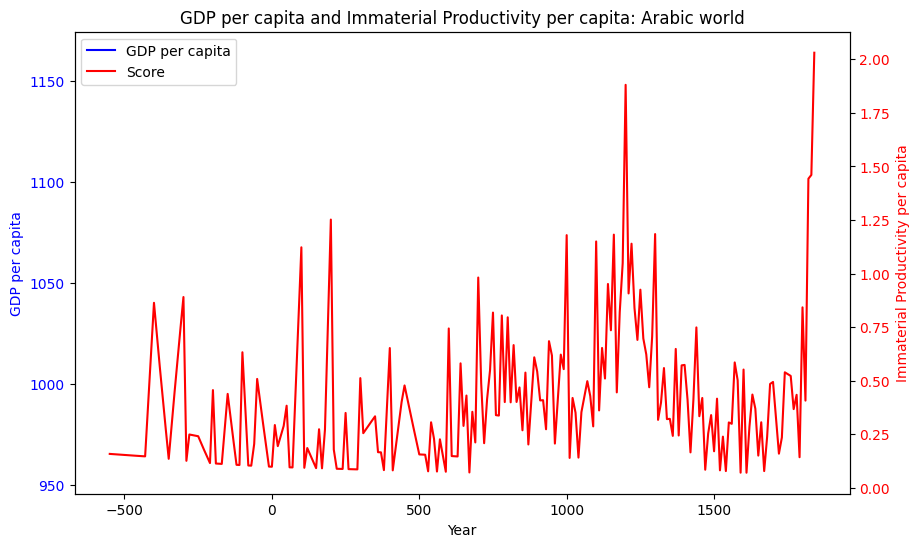

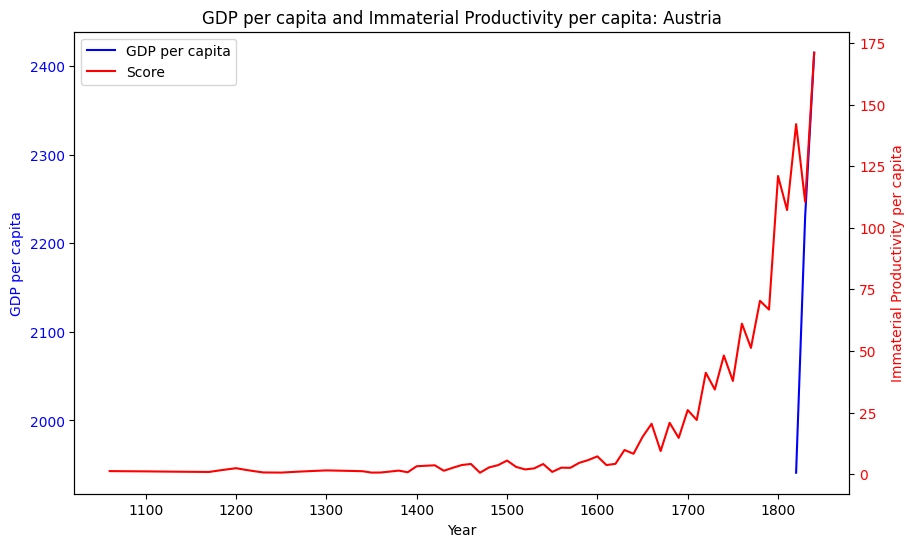

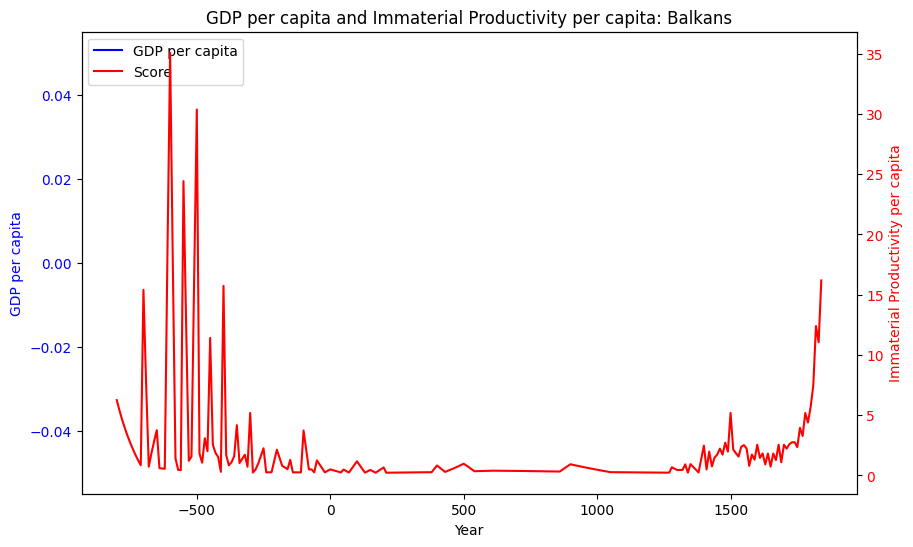

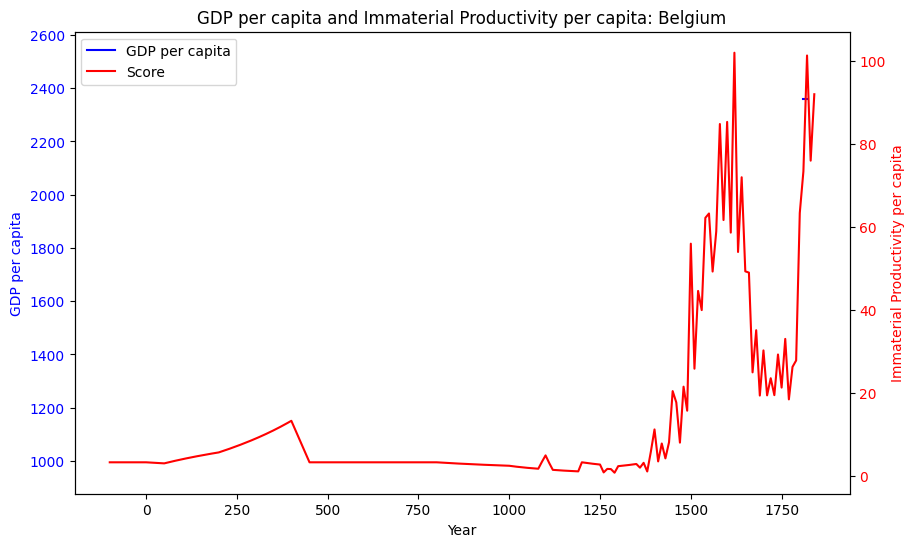

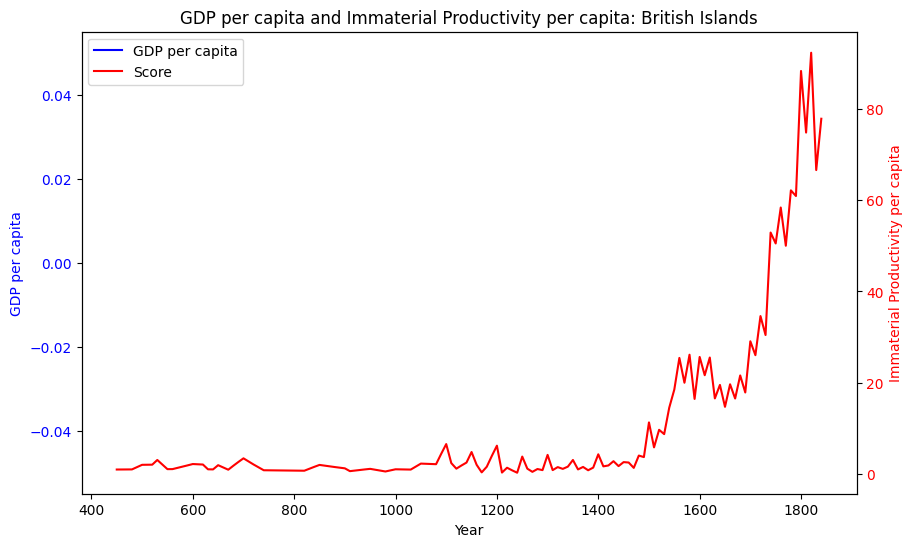

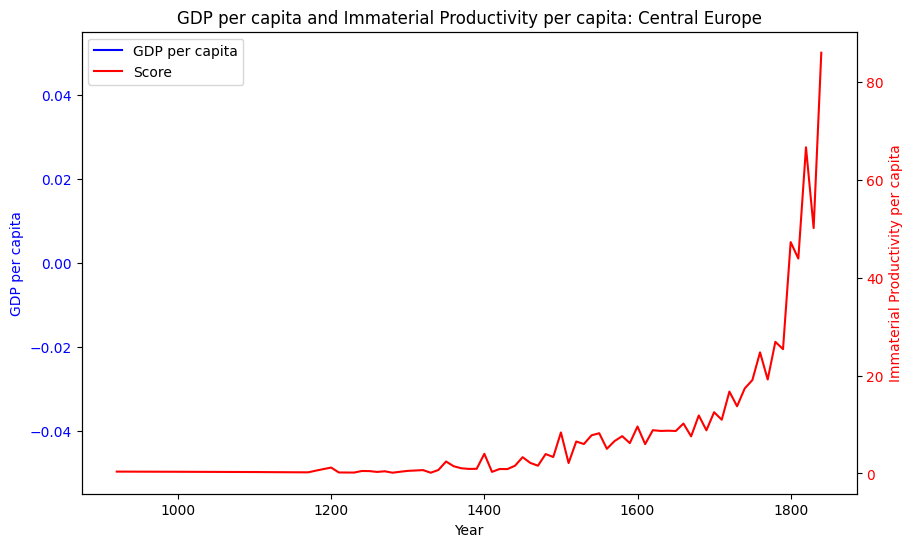

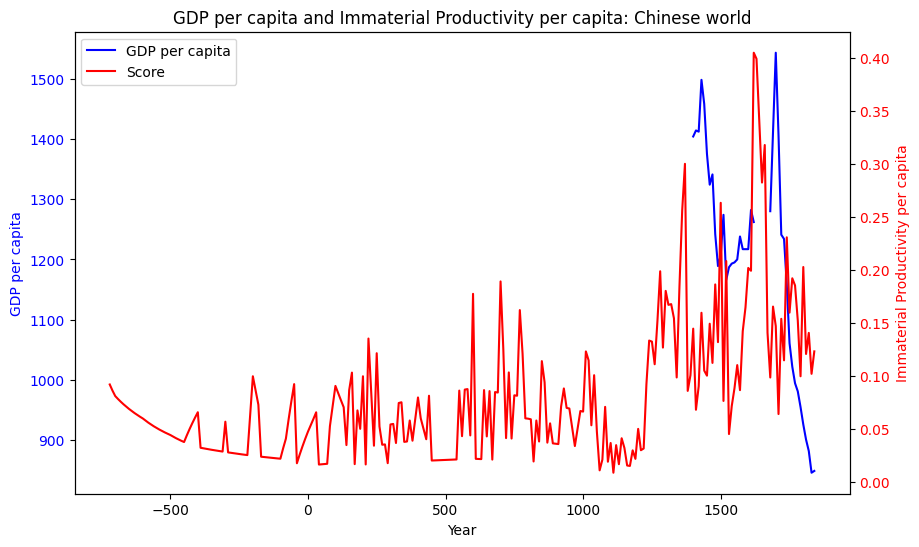

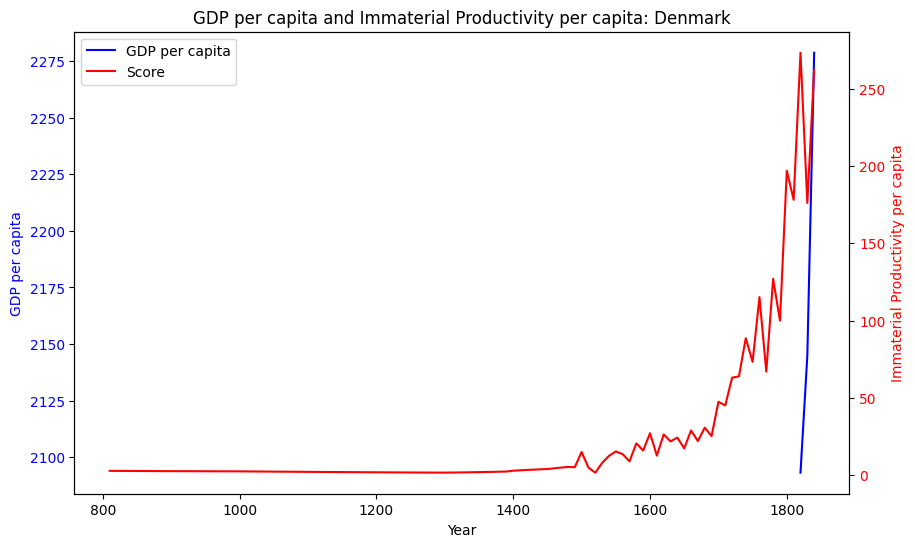

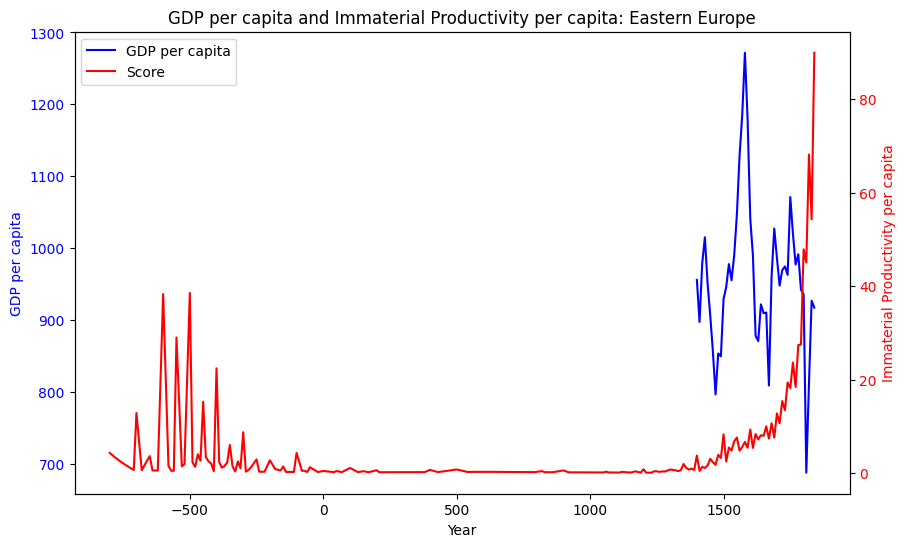

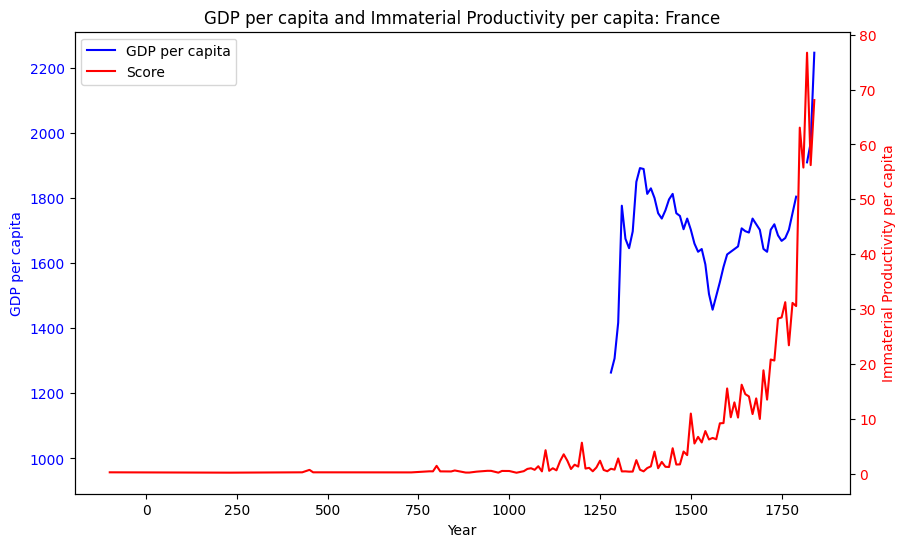

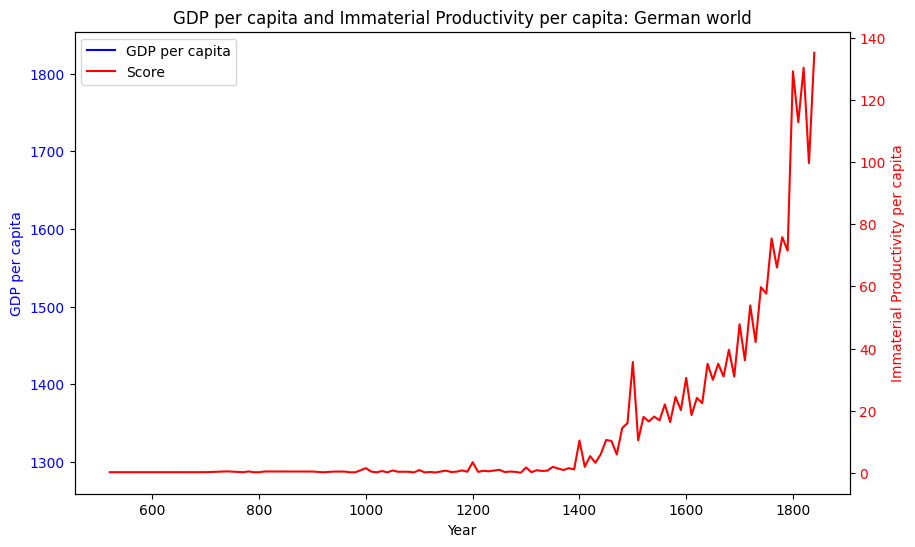

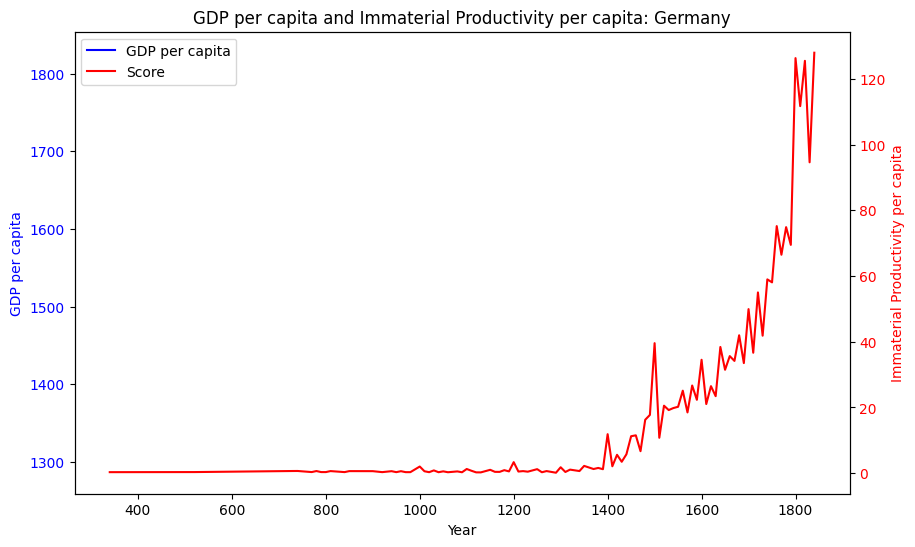

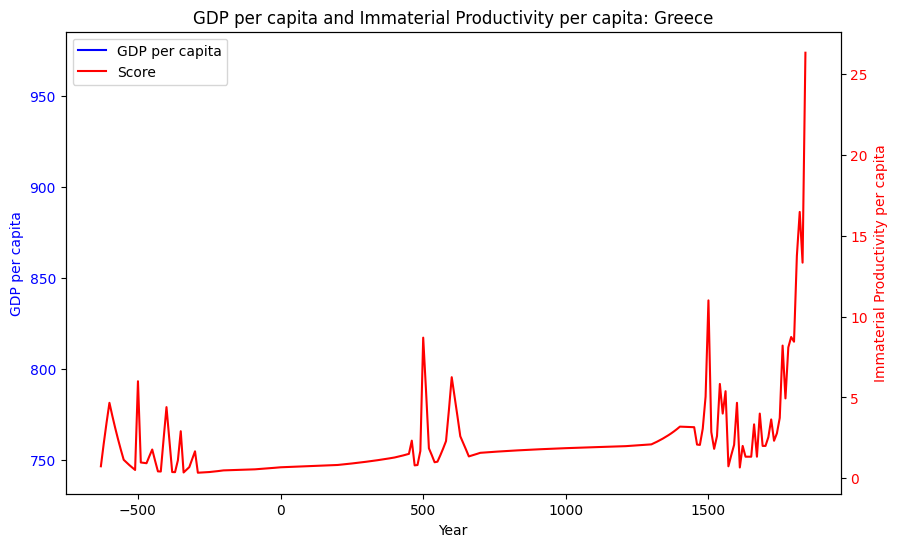

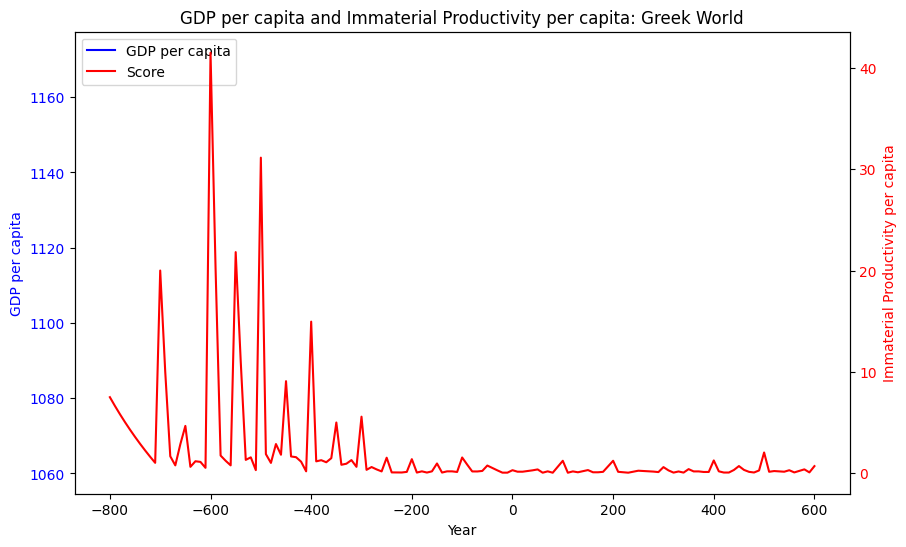

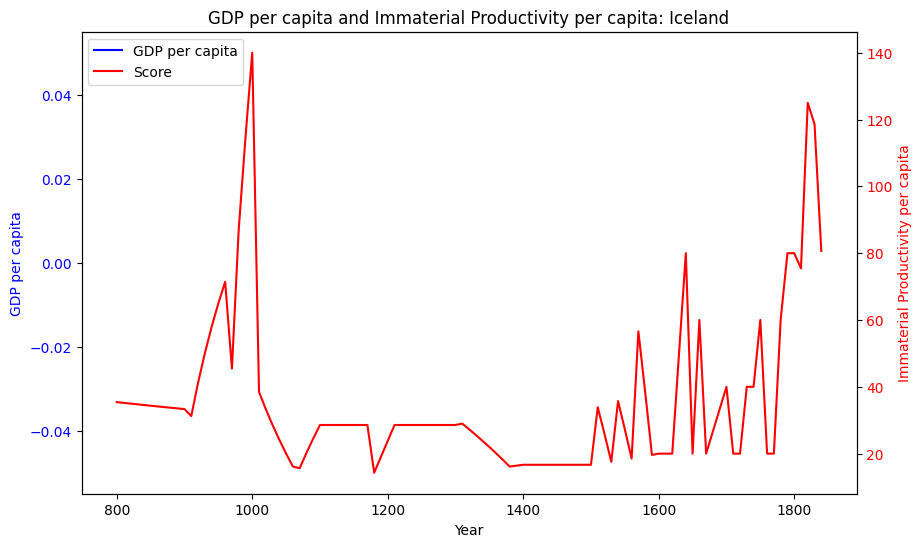

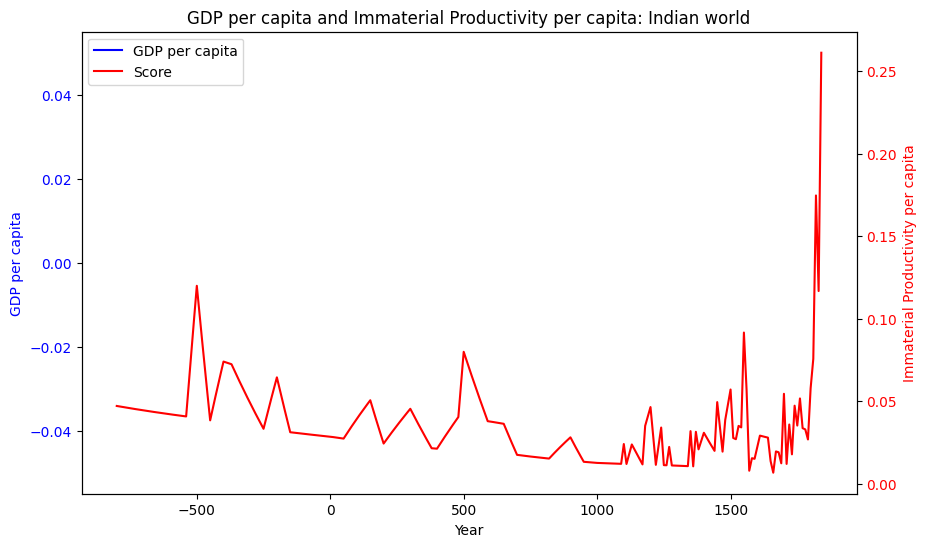

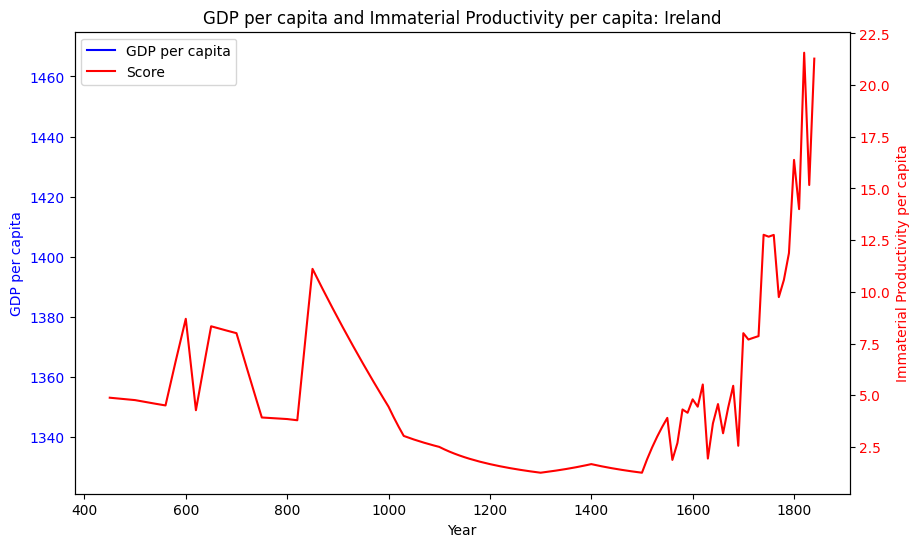

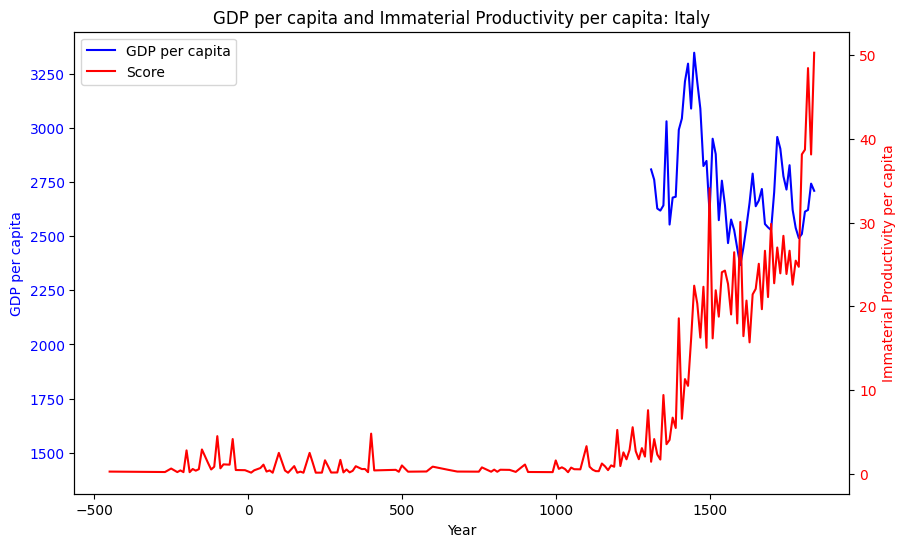

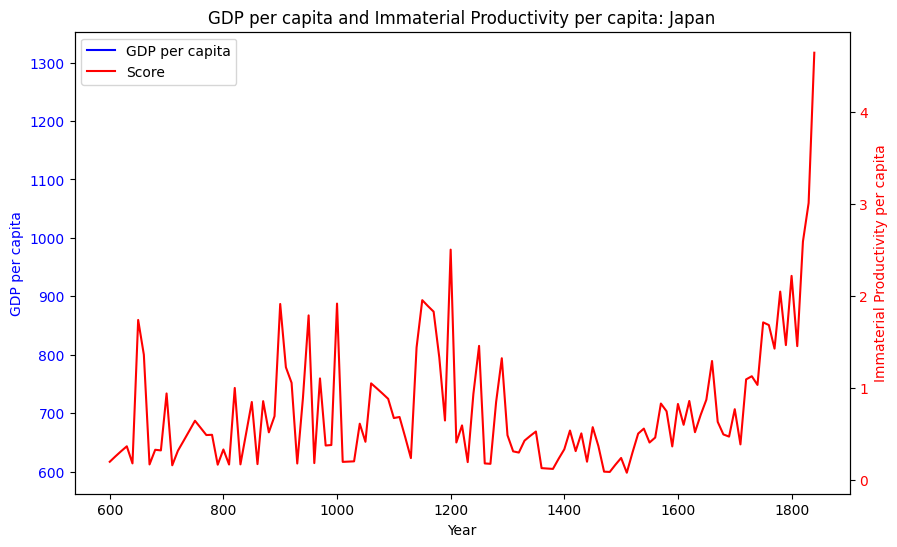

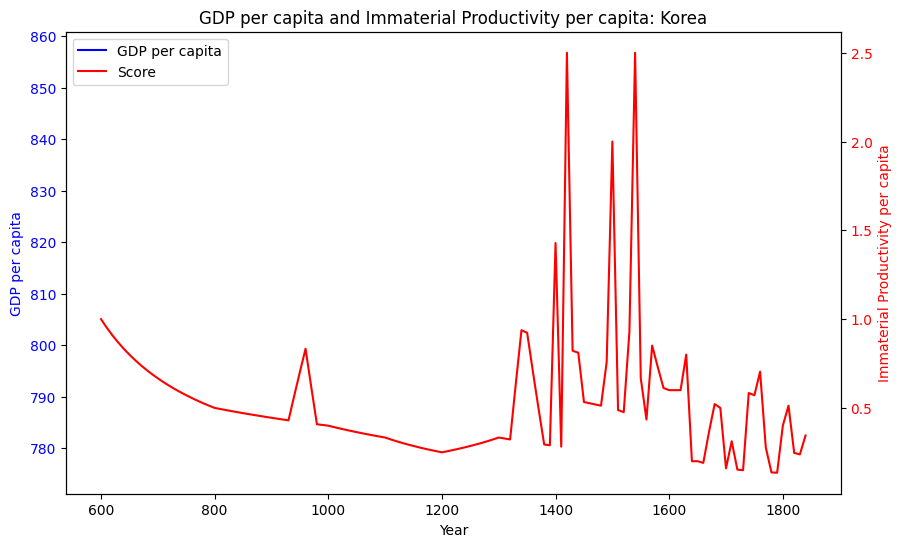

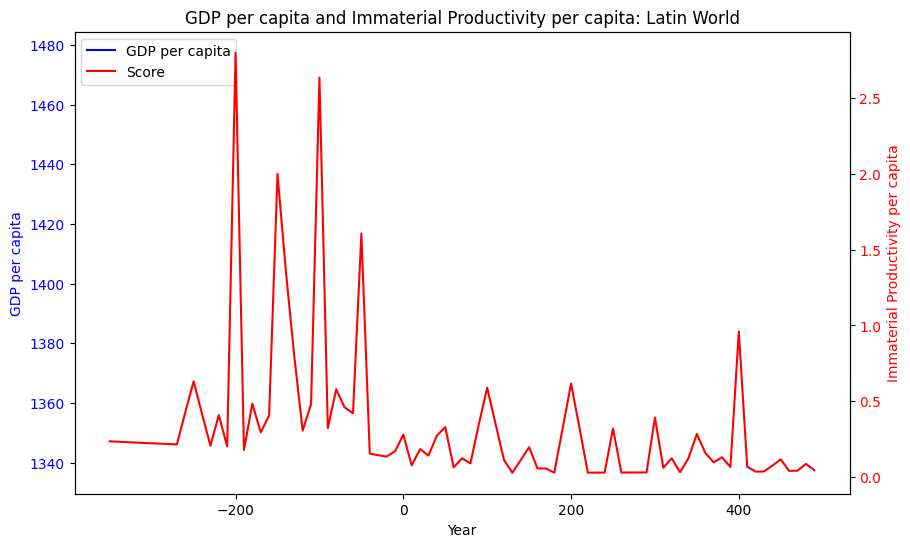

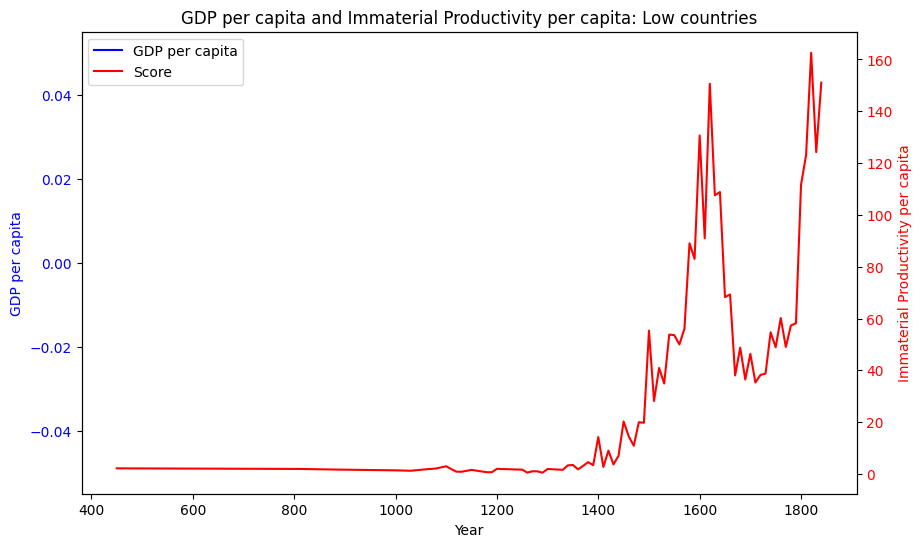

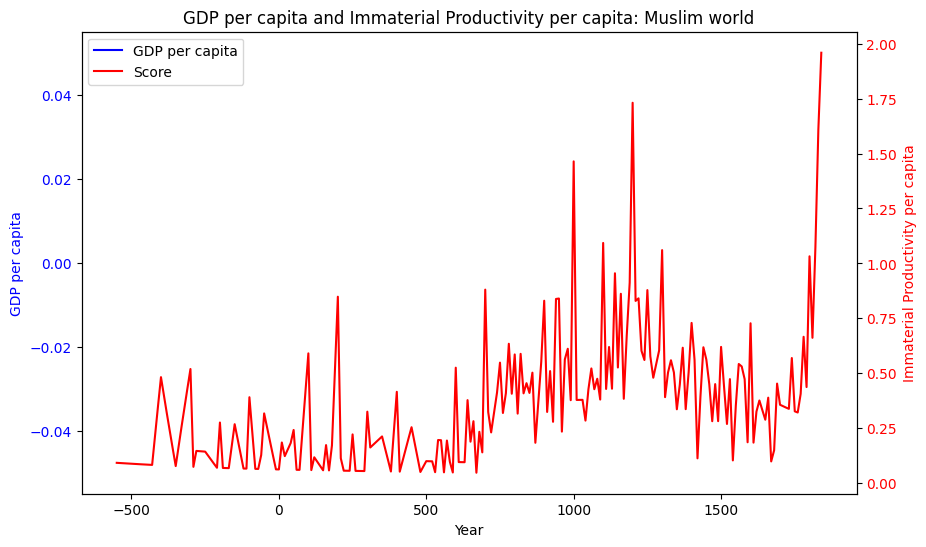

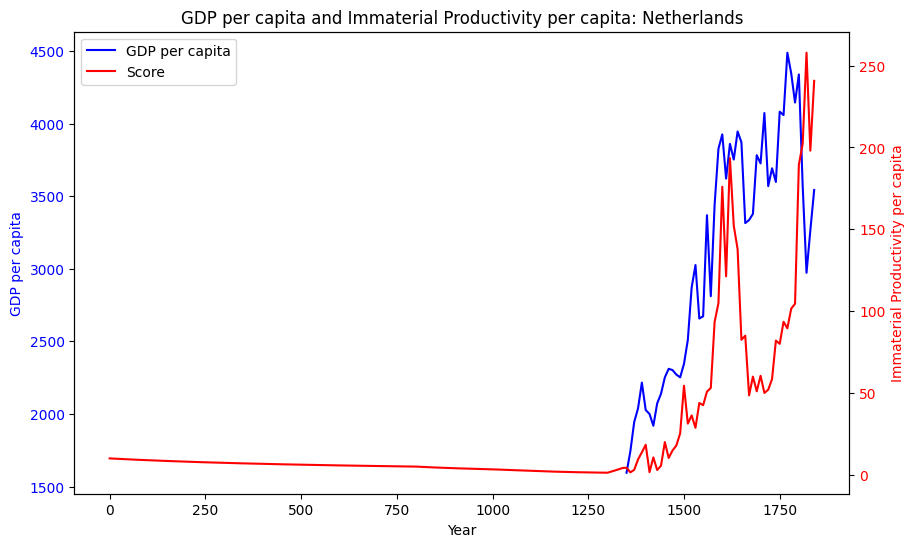

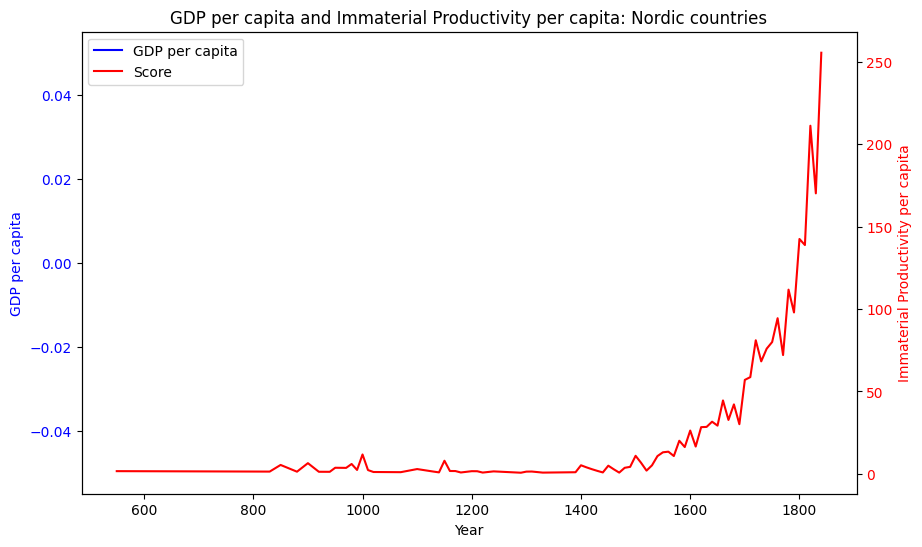

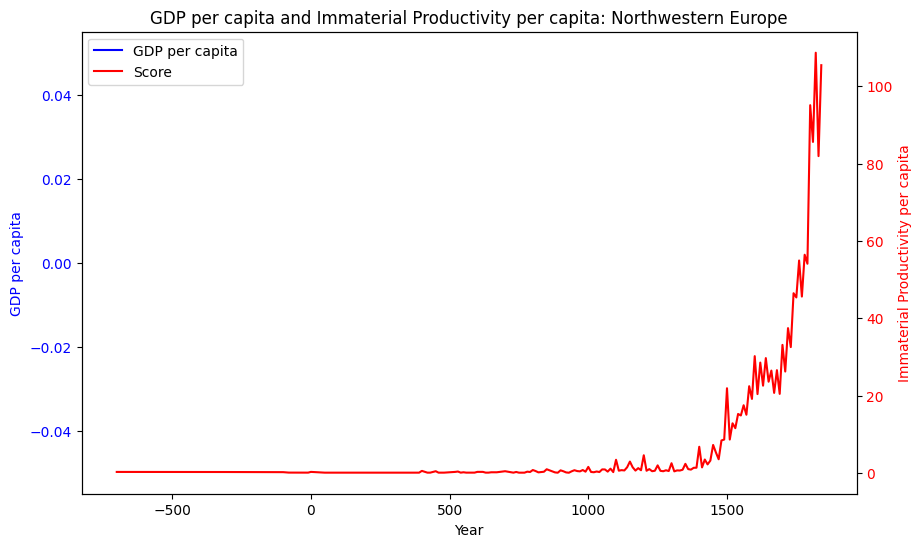

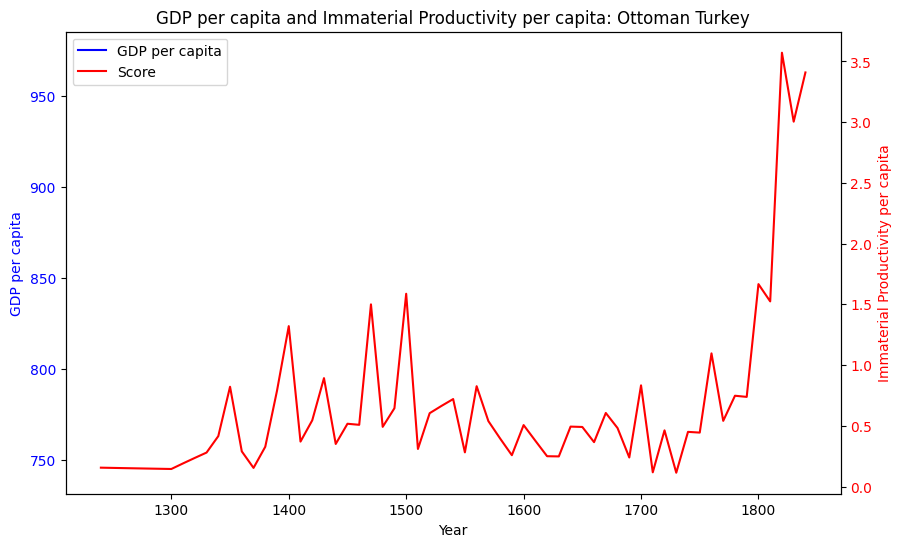

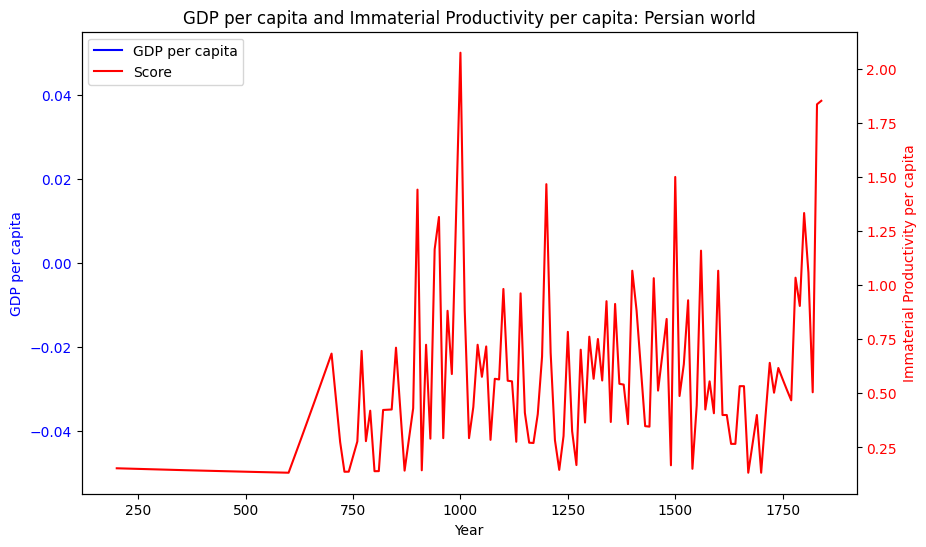

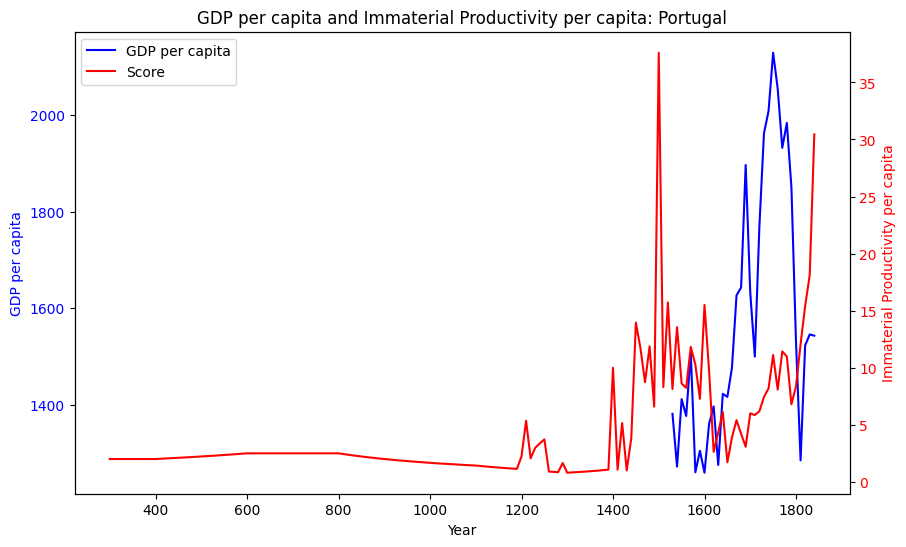

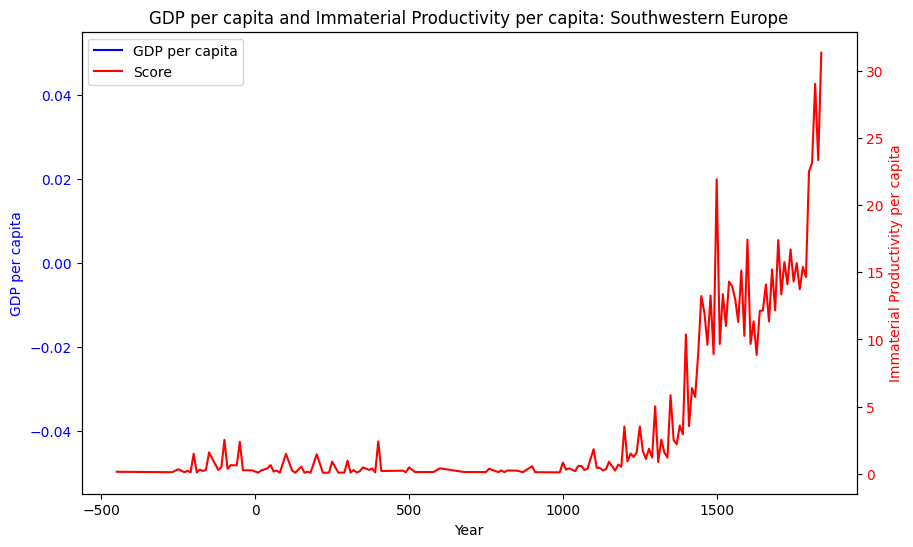

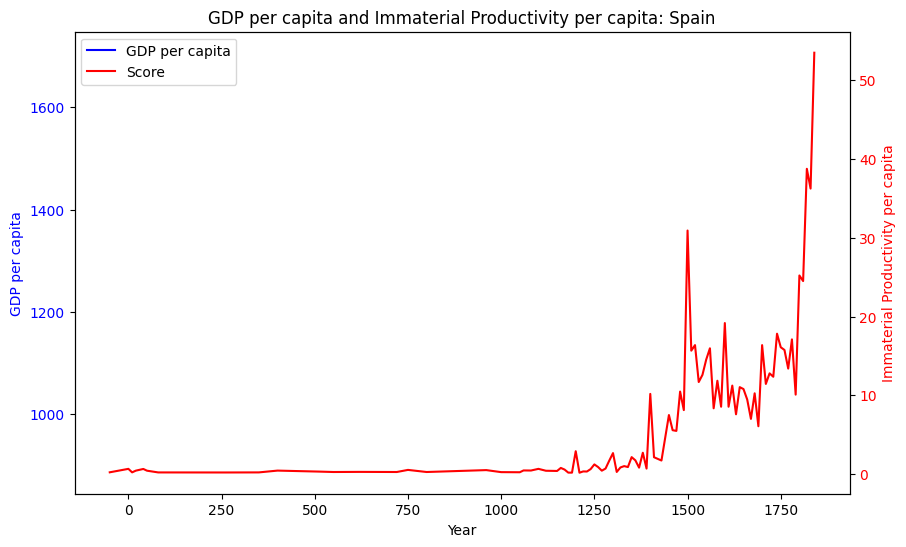

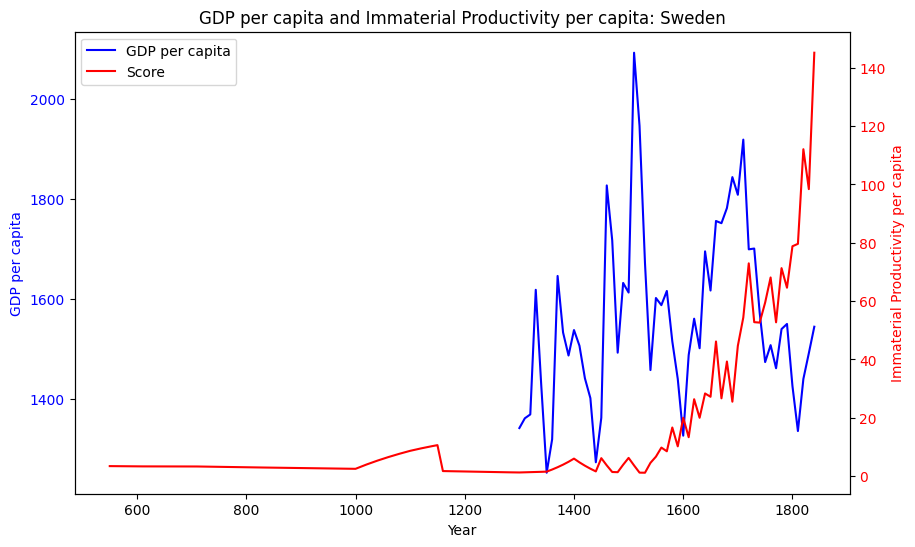

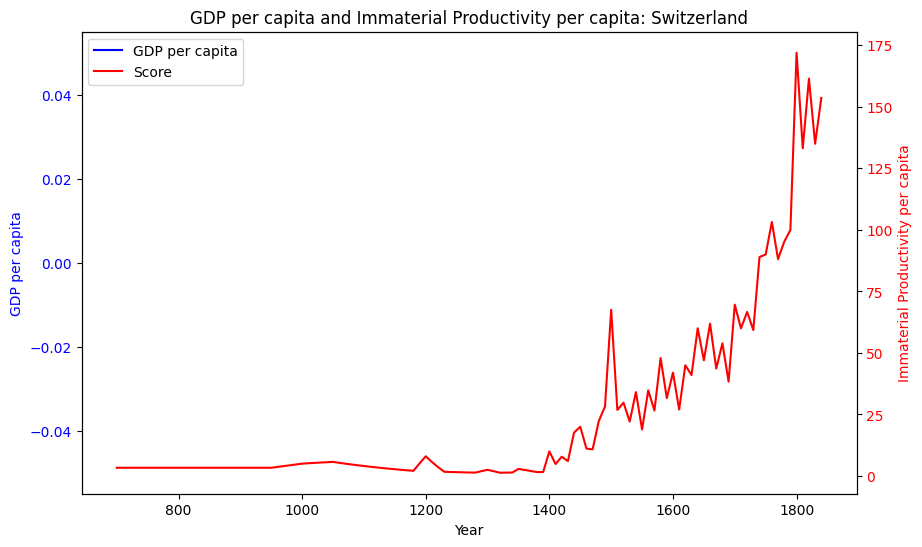

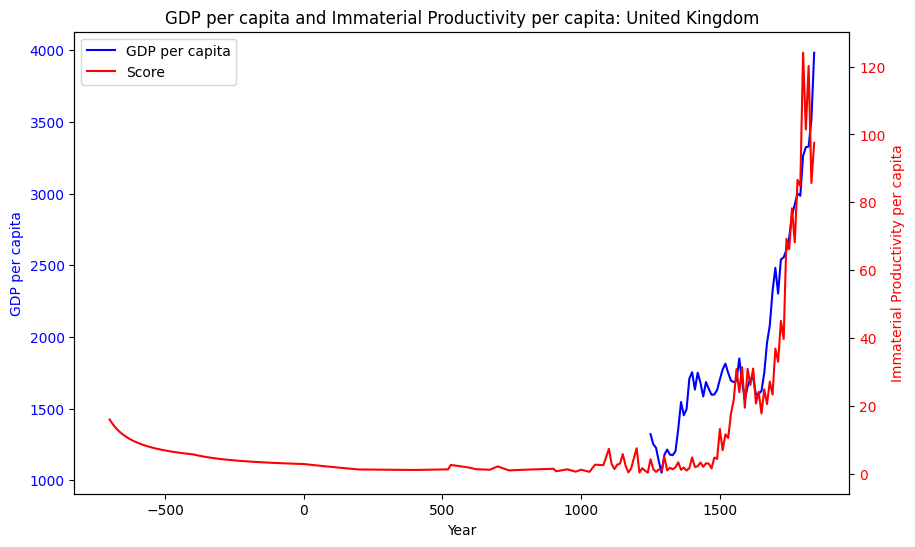

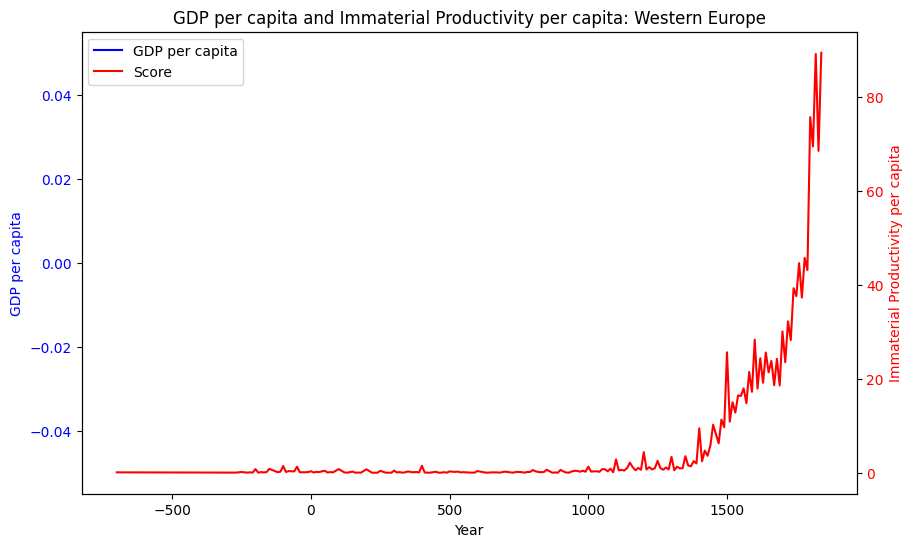

In [97]:
for reg in df_mix.region_name.unique():
    plot_both(region = reg)